In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np


gdf = gpd.read_file("C:/Users/Yoanna/Downloads/utm_centroids_with_distance116.gpkg")

# Before optimization

### Check what percentage of people have to walk a distance greater than 1500 metres to a drugstore in Salzburg

In [3]:
# Load the new GeoPackage file (assumed to be already saved with the new columns)
new_gpkg_path = "C:/Users/Yoanna/Downloads/utm_centroids_with_distance116.gpkg"
gdf = gpd.read_file(new_gpkg_path)

# Filter data for people who have to walk more than 1500 meters
people_above_1500m = gdf[gdf['adjusted_ex_distance'] > 1500]

# Sum the distributed population for those people
total_population_above_1500m = people_above_1500m['distributed_population'].sum()

# Sum the total distributed population
total_population = gdf['distributed_population'].sum()

# Calculate the percentage of the population that has to walk more than 1500 meters
percentage_above_1500m = (total_population_above_1500m / total_population) * 100

# Display the results
print(f"{total_population_above_1500m:.0f} people have to walk more than 1500 meters to reach a drugstore.")
print(f"{percentage_above_1500m:.2f}% of the population has to walk more than 1500 meters to reach a drugstore.")


32076 people have to walk more than 1500 meters to reach a drugstore.
20.31% of the population has to walk more than 1500 meters to reach a drugstore.


#### Check the number of residents and their distance walking over 1500 meters

Number of people who need to walk more than 1500 meters before new drugstores: 32076.0


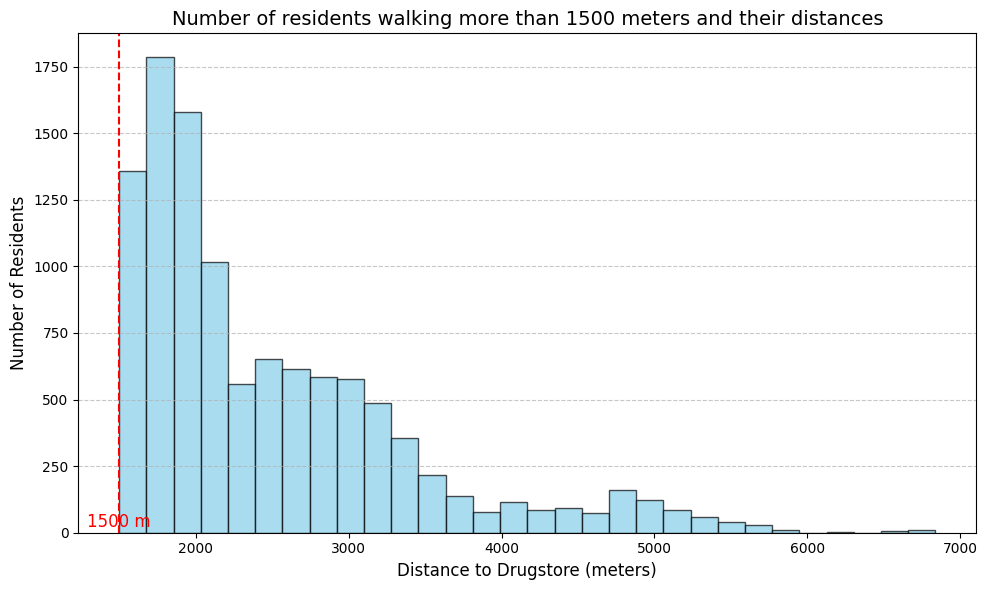

In [4]:
# 1. Number of people who must walk more than 1500 meters before new drugstores are opened
over_1500_before = gdf[gdf['adjusted_ex_distance'] > 1500]
num_over_1500_before = over_1500_before['distributed_population'].sum()

print(f"Number of people who need to walk more than 1500 meters before new drugstores: {num_over_1500_before}")

# 2. Plot histogram of distances for these people
plt.figure(figsize=(10, 6))

# Histogram of walking distances before building new drugstores
plt.hist(over_1500_before['adjusted_ex_distance'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add vertical line at 1500 meters threshold
plt.axvline(x=1500, color='red', linestyle='--')

# Add label '1500' under x-axis at the vertical line
plt.text(1500, plt.ylim()[0] + 5, '1500 m', color='red', fontsize=12, ha='center', va='bottom')

# Plot settings
plt.title('Number of residents walking more than 1500 meters and their distances', fontsize=14)
plt.xlabel('Distance to Drugstore (meters)', fontsize=12)
plt.ylabel('Number of Residents', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot with tight layout
plt.tight_layout()
plt.show()


#### Checking which districts have how many people without a drugstore within 1500 meters

In [5]:
# Filter data for people who have to walk more than 1500 meters
people_above_1500m = gdf[gdf['adjusted_ex_distance'] > 1500]

# Group by district and sum the distributed population
population_by_district = people_above_1500m.groupby('district_name')['distributed_population'].sum()

# Display the result
print("Total distributed population by district for people who have to walk more than 1500 meters:")
print(population_by_district)


Total distributed population by district for people who have to walk more than 1500 meters:
district_name
Aigen / Glas                                   2097.0
Gaisberg                                        131.0
Gnigl / Langwied                               2481.0
Hellbrunn                                       229.0
Itzling                                         208.0
Itzling-West / Hagenau                          730.0
Josefiau / Alpenstrasse-Ost                      41.0
Kapuzinerberg / Steinviertel                     33.0
Kleingmain / Morzg                              578.0
Leopoldskron / Moos                            7955.0
Liefering-Nord                                 6127.0
Liefering-Ost                                   683.0
Liefering-West                                    6.0
Maxglan                                         212.0
Maxglan / Flughafen                            3583.0
Maxglan / Riedenburg                             41.0
Monchsberg / Inneres Nonntal /

#### Classify city districts based on the presence of a drogerie (drugstore) and whether people in those districts have to walk more than 1500 meters to reach one.

The classification has three categories:

- "No drogerie, people > 1500m" – Districts that do not have a drogerie and contain residents who must walk more than 1500 meters to reach one.

- "Has drogerie, people > 1500m" – Districts that have a drogerie but still contain residents located more than 1500 meters away from it.

- "Has drogerie, all served" – Districts that have a drogerie and all residents are within a 1500-meter walking distance.

In [11]:
import geopandas as gpd

# Load the data
districts_path = "C:/Users/Yoanna/Downloads/utm_updated_zaehlbezirk.gpkg"
old_drogeries_path = "C:/Users/Yoanna/Downloads/retro_drogeries.gpkg"
utm_centroids_path = "C:/Users/Yoanna/Downloads/utm_centroids_with_distance116.gpkg"

districts = gpd.read_file(districts_path)          # Districts
old_drogeries = gpd.read_file(old_drogeries_path)  # Existing drogeries
utm_centroids = gpd.read_file(utm_centroids_path)  # Centroids with population and distances

# Group data for residents who have to walk more than 1500 meters
people_above_1500m = utm_centroids[utm_centroids['adjusted_ex_distance'] > 1500]
population_by_district = people_above_1500m.groupby('district_name')['distributed_population'].sum()

# Add a column to the districts showing the number of people walking more than 1500 meters
districts = districts.merge(population_by_district, how='left', left_on='NAME', right_on='district_name')
districts['distributed_population'] = districts['distributed_population'].fillna(0)  # Replace NaN with 0

# Find the districts that contain at least one drogerie
districts_with_drogerie = old_drogeries['district_name'].unique()

# Classification of districts
districts['category'] = 'No drogerie, people > 1500m'  # Default: no drogerie and people walking >1500m
districts.loc[
    (districts['NAME'].isin(districts_with_drogerie)) & (districts['distributed_population'] > 0),
    'category'
] = 'Has drogerie, people > 1500m'
districts.loc[
    (districts['NAME'].isin(districts_with_drogerie)) & (districts['distributed_population'] == 0),
    'category'
] = 'Has drogerie, all served'

# Results
no_drogerie = districts[districts['category'] == 'No drogerie, people > 1500m']
has_drogerie_people = districts[districts['category'] == 'Has drogerie, people > 1500m']
has_drogerie_all_served = districts[districts['category'] == 'Has drogerie, all served']

print("Districts without drogerie and people > 1500m:")
print(no_drogerie[['NAME', 'distributed_population']])

print("\nDistricts with drogerie and people > 1500m:")
print(has_drogerie_people[['NAME', 'distributed_population']])

print("\nDistricts with drogerie and all served:")
print(has_drogerie_all_served[['NAME']])


Districts without drogerie and people > 1500m:
                                           NAME  distributed_population
1                                     Hellbrunn                   229.0
2                               Thumegg / Gneis                     0.0
4                              Gnigl / Langwied                  2481.0
5                           Parsch-West / Aigen                   449.0
6                                Liefering-Nord                  6127.0
9                                       Maxglan                   212.0
10  Monchsberg / Inneres Nonntal / Leopoldskron                    18.0
12                                 Sam / Kasern                  3393.0
14                                     Neustadt                     0.0
16                          Leopoldskron / Moos                  7955.0
19                           Parsch-Ost / Aigen                  1808.0
20                                     Gaisberg                   131.0
21               

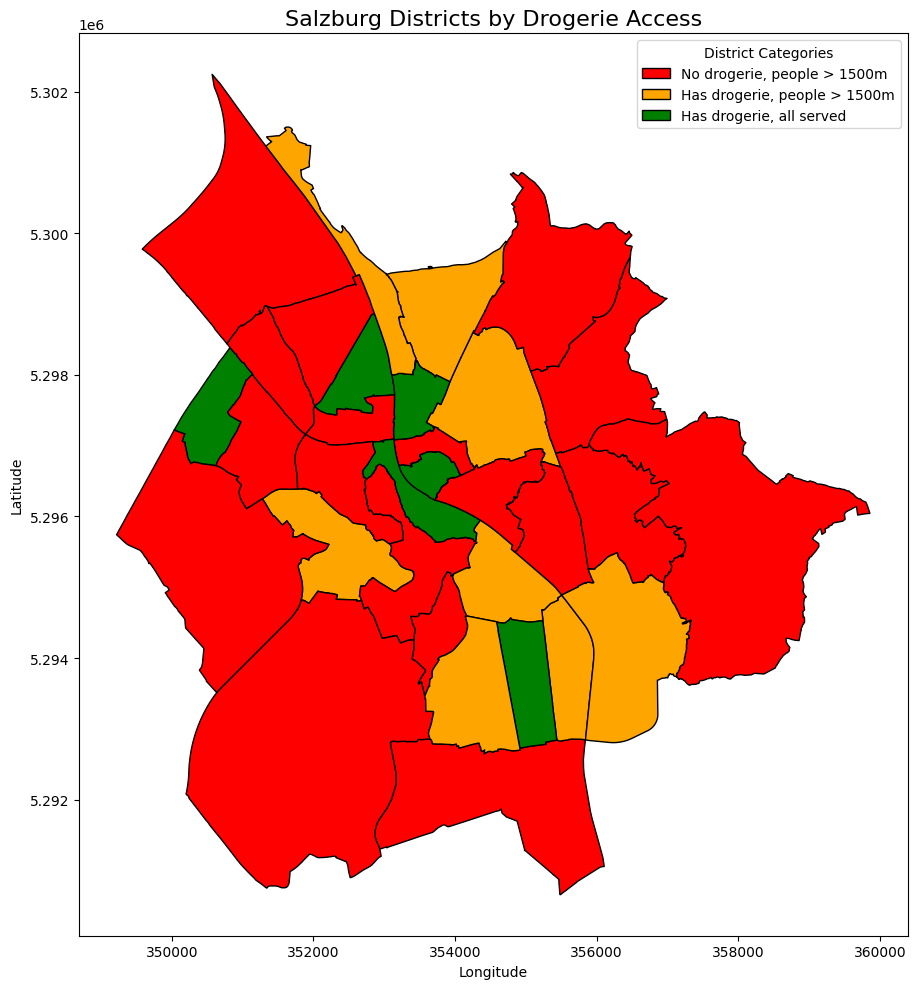

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- 1. Load the spatial data ---
districts_path = "C:/Users/Yoanna/Downloads/utm_updated_zaehlbezirk.gpkg"
old_drogeries_path = "C:/Users/Yoanna/Downloads/retro_drogeries.gpkg"
utm_centroids_path = "C:/Users/Yoanna/Downloads/utm_centroids_with_distance116.gpkg"

districts = gpd.read_file(districts_path)
old_drogeries = gpd.read_file(old_drogeries_path)
utm_centroids = gpd.read_file(utm_centroids_path)

# --- 2. Filter people who are more than 1500 meters away from a drogerie ---
people_above_1500m = utm_centroids[utm_centroids['adjusted_ex_distance'] > 1500]
population_by_district = people_above_1500m.groupby('district_name')['distributed_population'].sum()

# --- 3. Merge the population data into the districts data ---
districts = districts.merge(population_by_district, how='left', left_on='NAME', right_on='district_name')
districts['distributed_population'] = districts['distributed_population'].fillna(0)

# --- 4. Identify districts that already have a drogerie ---
districts_with_drogerie = old_drogeries['district_name'].unique()

# --- 5. Categorize districts based on drogerie access ---
districts['category'] = 'No drogerie, people > 1500m'
districts.loc[
    (districts['NAME'].isin(districts_with_drogerie)) & (districts['distributed_population'] > 0),
    'category'
] = 'Has drogerie, people > 1500m'
districts.loc[
    (districts['NAME'].isin(districts_with_drogerie)) & (districts['distributed_population'] == 0),
    'category'
] = 'Has drogerie, all served'

# --- 6. Define colors for each category ---
category_colors = {
    'No drogerie, people > 1500m': 'red',
    'Has drogerie, people > 1500m': 'orange',
    'Has drogerie, all served': 'green'
}

# Map colors to each district; fallback to 'gray' for unexpected values
districts['color'] = districts['category'].map(category_colors).fillna('gray')

# --- 7. Plot the map visualization ---
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot districts colored by drogerie access category
districts.plot(ax=ax, color=districts['color'], edgecolor='black')

# Manually define the legend
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='No drogerie, people > 1500m'),
    Patch(facecolor='orange', edgecolor='black', label='Has drogerie, people > 1500m'),
    Patch(facecolor='green', edgecolor='black', label='Has drogerie, all served'),
    #Patch(facecolor='gray', edgecolor='black', label='Unknown category')
]
ax.legend(handles=legend_elements, title="District Categories", loc='upper right')

# Add title and axis labels
plt.title("Salzburg Districts by Drogerie Access", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()


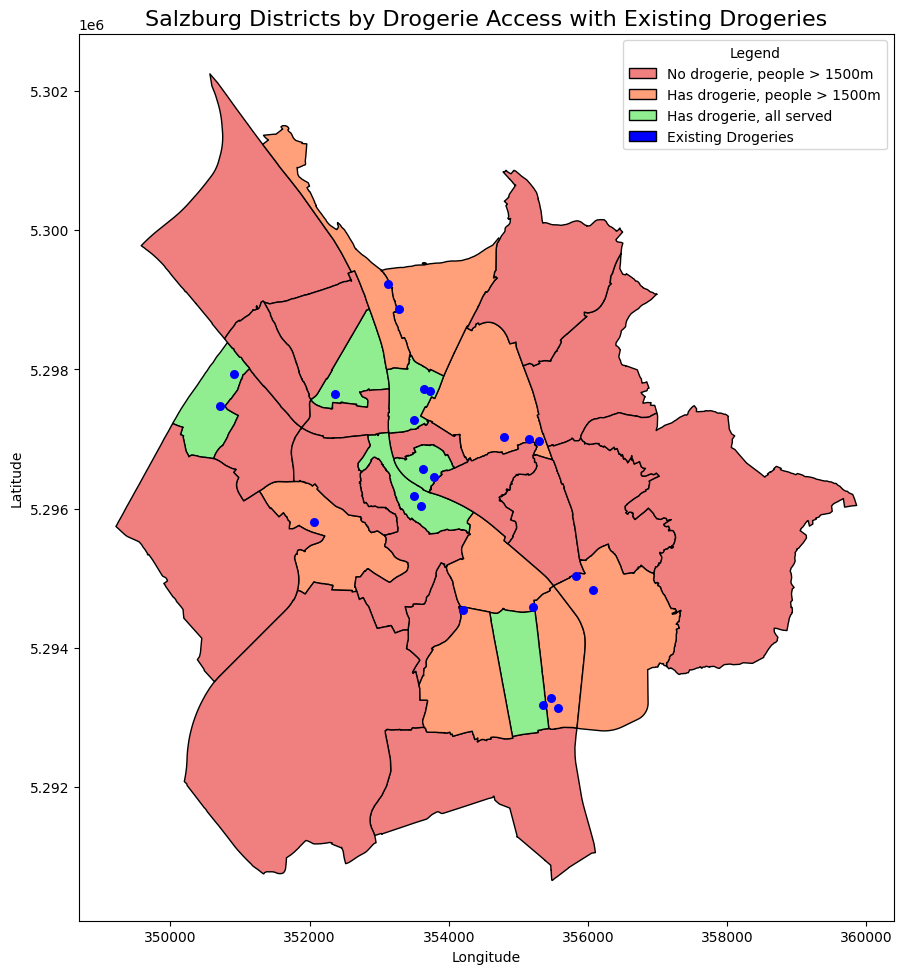

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Colors for the categories
category_colors = {
    'No drogerie, people > 1500m': 'lightcoral',   # Lighter red
    'Has drogerie, people > 1500m': 'lightsalmon', # Lighter orange
    'All served': 'lightgreen'                      # Lighter green
}

# Create a new column for the colors, fill missing categories with 'white'
districts['color'] = districts['category'].map(category_colors).fillna('lightgreen')

# Load data for the centroids of the drogerie locations
utm_centroids_path = "C:/Users/Yoanna/Downloads/utm_centroids_with_distance12.gpkg"
utm_centroids = gpd.read_file(utm_centroids_path)

# List of 'id' values of the centroids to visualize
target_ids = [
    'way/29280820', 'way/45393138', 'way/48894570', 'way/51070174', 'way/54827797', 
    'way/55227682', 'way/56080144', 'way/56125682', 'way/64132614', 'way/64132870', 
    'way/66058244', 'way/66209398', 'way/96856587', 'way/98347136', 'way/127497381', 
    'way/136339345', 'way/139752447', 'way/171436447', 'way/236372677', 'way/552204886', 
    'way/956550043', 'way/1274259281', 'way/1259480108'
]

# Filter centroids by 'id'
centroids_filtered = utm_centroids[utm_centroids['id'].isin(target_ids)]

# Visualization of the map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot districts colored by category
districts.plot(ax=ax, color=districts['color'], edgecolor='black')

# Add centroids of the old drogeries
centroids_filtered.plot(ax=ax, color='blue', markersize=30, label='Old Drogerie Centroids')

# Manually add a legend
legend_elements = [
    Patch(facecolor='lightcoral', edgecolor='black', label='No drogerie, people > 1500m'),
    Patch(facecolor='lightsalmon', edgecolor='black', label='Has drogerie, people > 1500m'),
    Patch(facecolor='lightgreen', edgecolor='black', label='Has drogerie, all served'),
    Patch(facecolor='blue', edgecolor='black', label='Existing Drogeries')  # Bright blue markers for drogeries
]
ax.legend(handles=legend_elements, title="Legend", loc='upper right')

# Title and labels
plt.title("Salzburg Districts by Drogerie Access with Existing Drogeries", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the map
plt.tight_layout()
plt.show()


#### Visualize the number of residents in each district who must walk more than 1500 meters to reach a drugstore: 
Create a horizontal bar chart where each bar represents a district and the number of underserved residents:

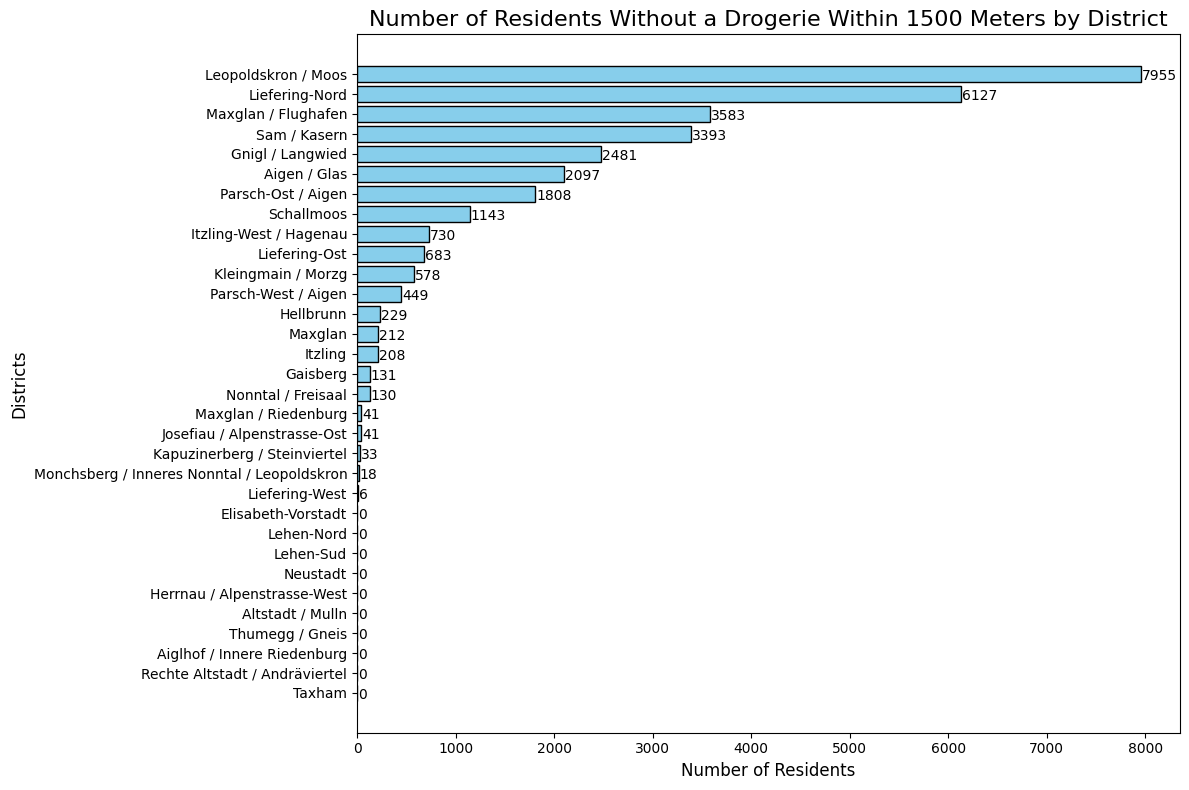

In [8]:
import matplotlib.pyplot as plt

# Prepare the data
districts_sorted = districts.sort_values('distributed_population', ascending=False)  # Sort districts by population
district_names = districts_sorted['NAME']  # District names
population_no_access = districts_sorted['distributed_population']  # Residents without access within 1500m

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(district_names, population_no_access, color='skyblue', edgecolor='black')

# Add title and axis labels
ax.set_title('Number of Residents Without a Drogerie Within 1500 Meters by District', fontsize=16)
ax.set_xlabel('Number of Residents', fontsize=12)
ax.set_ylabel('Districts', fontsize=12)

# Add value labels to each bar
for i in ax.patches:
    ax.text(i.get_width() + 10, i.get_y() + 0.5, f'{int(i.get_width())}', fontsize=10, verticalalignment='center')

# Reverse the Y-axis for better readability (largest bar on top)
plt.gca().invert_yaxis()

# Display the chart
plt.tight_layout()
plt.show()


# After Optimisation

## Analyze the accessibility of drogeries (drugstores) in Salzburg after new drogeries have been built.

In [2]:
import geopandas as gpd

# Load the datasets
districts_path_new = "C:/Users/Yoanna/Downloads/utm_updated_zaehlbezirk.gpkg"
old_drogeries_path_new = "C:/Users/Yoanna/Downloads/pravilnite_drog_ids.gpkg"
utm_centroids_path_new = "C:/Users/Yoanna/Downloads/utm_centroids_with_distance116.gpkg"

districts_after = gpd.read_file(districts_path_new)  # Districts (after new drogeries)
old_drogeries_after = gpd.read_file(old_drogeries_path_new)  # Newly built drogeries
utm_centroids_after = gpd.read_file(utm_centroids_path_new)  # Centroids (after new drogeries)

# Group population with >1500m distance after new drogeries were built
people_above_1500m_after = utm_centroids_after[utm_centroids_after['mynewdrog_distance'] > 1500]
population_by_district_after = people_above_1500m_after.groupby('district_name')['distributed_population'].sum()

# Add a column for people without access after construction
districts_after = districts_after.merge(population_by_district_after, how='left', left_on='NAME', right_on='district_name')
districts_after['distributed_population'] = districts_after['distributed_population'].fillna(0)

# Sort districts by name for easier visualization
districts_after = districts_after.sort_values('NAME')


### Calculate the average walking distance to the nearest drogerie per person across Salzburg after the addition of new drogeries

In [3]:
# Load the updated GeoPackage file (assumed to include the new columns)
new_gpkg_path = r"C:\Users\Yoanna\Downloads\utm_centroids_with_distance116.gpkg"  # Added r for raw string
gdf = gpd.read_file(new_gpkg_path)

# Calculate the total sum of distances weighted by distributed population
gdf['weighted_distance'] = gdf['mynewdrog_distance'] * gdf['distributed_population']

# Sum the weighted distances
total_weighted_distance = gdf['weighted_distance'].sum()

# Sum the total distributed population
total_population = gdf['distributed_population'].sum()

# Calculate the average walking distance per person
average_distance_per_person = total_weighted_distance / total_population

# Print the result
print(f"Average distance one person has to walk to the nearest drogerie: {average_distance_per_person:.2f} meters.")


Average distance one person has to walk to the nearest drogerie: 632.02 meters.


### Analyze access to drugstores (drogeries) in different districts of Salzburg by calculating how many people in each district need to walk more than 1500 meters to reach the nearest drogerie

In [7]:
# Load the data
districts_path = "C:/Users/Yoanna/Downloads/utm_updated_zaehlbezirk.gpkg"
old_drogeries_path = "C:/Users/Yoanna/Downloads/pravilnite_drog_ids.gpkg"
utm_centroids_path = "C:/Users/Yoanna/Downloads/utm_centroids_with_distance116.gpkg"

districts = gpd.read_file(districts_path)  # Districts
old_drogeries = gpd.read_file(old_drogeries_path)  # Old drogeries
utm_centroids = gpd.read_file(utm_centroids_path)  # Centroids with population and distances

# Group data for people walking more than 1500 meters
people_above_1500m = utm_centroids[utm_centroids['mynewdrog_distance'] > 1500]
population_by_district = people_above_1500m.groupby('district_name')['distributed_population'].sum()

# Add a column for the population walking more than 1500 meters in the districts
districts = districts.merge(population_by_district, how='left', left_on='NAME', right_on='district_name')
districts['distributed_population'] = districts['distributed_population'].fillna(0)  # Replace NaN with 0

# Find districts that have at least one drogerie
districts_with_drogerie = old_drogeries['district_name'].unique()

# Classify the districts
districts['category'] = 'No drogerie, people > 1500m'  # Default: no drogerie

# Districts that have a drogerie and still have people walking > 1500 m
districts.loc[(districts['NAME'].isin(districts_with_drogerie)) & 
              (districts['distributed_population'] > 0), 'category'] = 'Has drogerie, people > 1500m'

# Districts where all people are served, regardless of whether there's a drogerie in the district
districts.loc[districts['distributed_population'] == 0, 'category'] = 'All served'

# Results
no_drogerie = districts[districts['category'] == 'No drogerie, people > 1500m']
has_drogerie_people = districts[districts['category'] == 'Has drogerie, people > 1500m']
all_served = districts[districts['category'] == 'All served']

# Print results
print("Districts without drogerie and people > 1500m:")
print(no_drogerie[['NAME', 'distributed_population']])

print("\nDistricts with drogerie and people > 1500m:")
print(has_drogerie_people[['NAME', 'distributed_population']])

print("\nDistricts where all are served:")
print(all_served[['NAME']])


Districts without drogerie and people > 1500m:
                                           NAME  distributed_population
10  Monchsberg / Inneres Nonntal / Leopoldskron                    17.0
26                 Kapuzinerberg / Steinviertel                     1.0

Districts with drogerie and people > 1500m:
                           NAME  distributed_population
1                     Hellbrunn                    10.0
3                    Schallmoos                   446.0
4              Gnigl / Langwied                    41.0
5           Parsch-West / Aigen                    63.0
6                Liefering-Nord                   204.0
7          Maxglan / Riedenburg                    21.0
8   Josefiau / Alpenstrasse-Ost                     6.0
11           Nonntal / Freisaal                    30.0
12                 Sam / Kasern                    26.0
16          Leopoldskron / Moos                   947.0
19           Parsch-Ost / Aigen                    93.0
20                  

### Geographical distribution of drugstores (drogeries) in Salzburg by:
#### -Loading spatial data for districts and the locations of old and new drugstores.
#### -Filtering the new drogeries to keep only those that were not already present before (i.e., newly added).
#### -Plotting a map:
    - Districts in gray.
    - Old drogeries in blue.
    - Newly added drogeries in green.

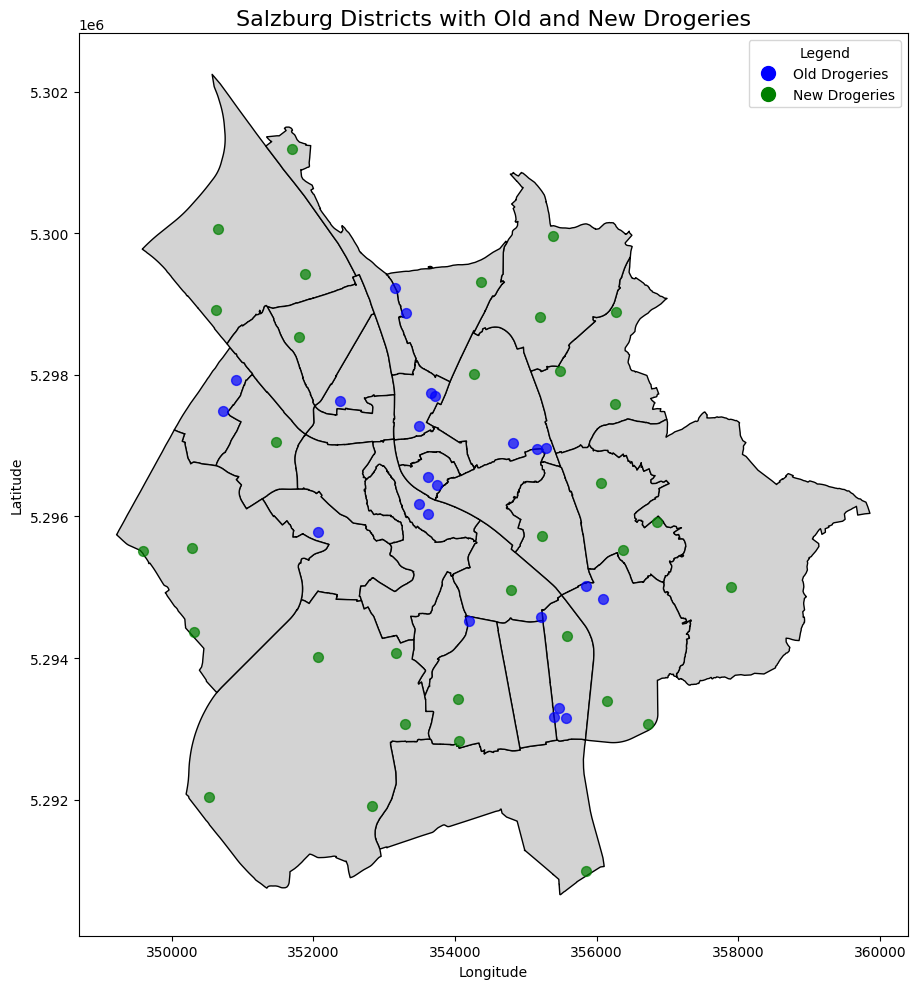

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D 

# Load data for districts and centroids of drogeries
utm_centroids_path = "C:/Users/Yoanna/Downloads/utm_centroids_with_distance116.gpkg"
utm_centroids = gpd.read_file(utm_centroids_path)

# Load data for old and new drogeries
old_drogeries_path = "C:/Users/Yoanna/Downloads/ok_existing_drogerie.gpkg"
new_drogeries_path = "C:/Users/Yoanna/Downloads/pravilnite_drog_ids.gpkg"

# Read the old and new drogeries
old_drogeries = gpd.read_file(old_drogeries_path)
new_drogeries = gpd.read_file(new_drogeries_path)

# Extract IDs of the old drogeries
old_drogeries_ids = old_drogeries['id'].tolist()

# Filter the new drogeries to show only those that are not in the list of old ones
new_drogeries_filtered = new_drogeries[~new_drogeries['id'].isin(old_drogeries_ids)]

# Visualization of the map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the districts without a color map
districts.plot(ax=ax, color='lightgray', edgecolor='black')

# Add the old drogeries with blue markers
old_drogeries.plot(ax=ax, color='blue', markersize=50, label='Old Drogeries', alpha=0.7)

# Add the new drogeries with green markers
new_drogeries_filtered.plot(ax=ax, color='green', markersize=50, label='New Drogeries', alpha=0.7)

# Add a custom legend manually
legend_elements = [
    Line2D([0], [0], color='blue', marker='o', markersize=10, linestyle='', label='Old Drogeries'),
    Line2D([0], [0], color='green', marker='o', markersize=10, linestyle='', label='New Drogeries')
]
ax.legend(handles=legend_elements, title="Legend", loc='upper right')

# Title and axis labels
plt.title("Salzburg Districts with Old and New Drogeries", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the map
plt.tight_layout()
plt.show()


In [10]:
districts_path_before = "C:/Users/Yoanna/Downloads/utm_updated_zaehlbezirk.gpkg"
old_drogeries_path_before = "C:/Users/Yoanna/Downloads/ok_existing_drogerie.gpkg" 
utm_centroids_path_before = "C:/Users/Yoanna/Downloads/utm_centroids_with_distance12.gpkg"

districts_before = gpd.read_file(districts_path_before)  # Districts
old_drogeries_before = gpd.read_file(old_drogeries_path_before)  # Old drogeries
utm_centroids_before = gpd.read_file(utm_centroids_path_before)  # Centroids with population and distances

# Group the data for people walking more than 1500 meters
people_above_1500m_before = utm_centroids_before[utm_centroids_before['adjusted_ex_distance'] > 1500]
population_by_district_before = people_above_1500m_before.groupby('district_name')['distributed_population'].sum()

# Add a column for the population walking more than 1500 meters per district
districts_before = districts_before.merge(population_by_district_before, how='left', left_on='NAME', right_on='district_name')
districts_before['distributed_population'] = districts_before['distributed_population'].fillna(0)  # Replace NaN with 0

# Identify districts that have at least one drogerie
districts_with_drogerie_before = old_drogeries_before['district_name'].unique()

# Classify the districts
districts_before['category'] = 'No drogerie, people > 1500m'  # Default: no drogerie, people walking too far
districts_before.loc[
    (districts_before['NAME'].isin(districts_with_drogerie_before)) & 
    (districts_before['distributed_population'] > 0), 
    'category'
] = 'Has drogerie, people > 1500m'

districts_before.loc[
    (districts_before['NAME'].isin(districts_with_drogerie_before)) & 
    (districts_before['distributed_population'] == 0), 
    'category'
] = 'Has drogerie, all served'

### Visualize the impact of adding new drogeries in terms of population accessibility:

#### -Compares the number of people in each district living farther than 1500 meters from a drogerie before and after new drogeries are introduced.

#### -Filters out districts where there is no improvement (i.e., no change).

#### -Sorts the districts by the amount of improvement (largest population reduction at the top).


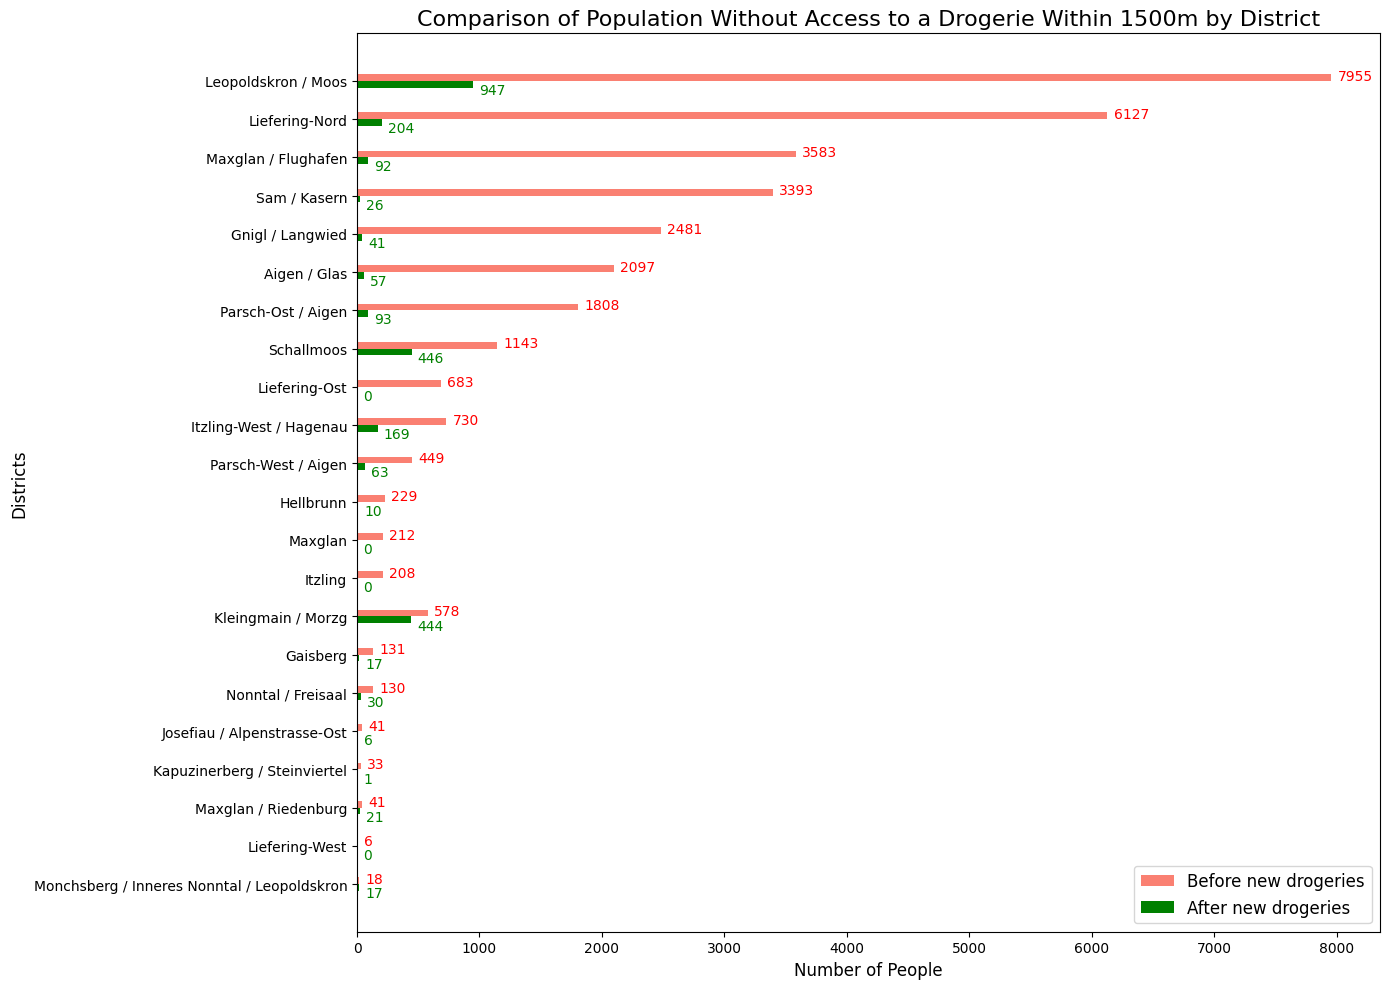

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the difference in population without access (before - after)
districts_before['difference'] = districts_before['distributed_population'] - districts_after['distributed_population']

# Filter out districts with no change
districts_before = districts_before[districts_before['difference'] != 0]
districts_after = districts_after.reindex(districts_before.index)

# Sort the data by the difference in descending order
districts_before = districts_before.sort_values('difference', ascending=False)
districts_after = districts_after.reindex(districts_before.index)

# District names
district_names = districts_before['NAME']

# Population without access before and after
population_before = districts_before['distributed_population']
population_after = districts_after['distributed_population']

# Bar positions with increased spacing
x = np.arange(len(district_names)) * 2

# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))
bar_width = 0.35  # Width of the bars

# Bars for "before"
bars_before = ax.barh(x - bar_width / 2, population_before, bar_width, color='salmon', label='Before new drogeries')

# Bars for "after"
bars_after = ax.barh(x + bar_width / 2, population_after, bar_width, color='green', label='After new drogeries')

# Axis labels and title
ax.set_title('Comparison of Population Without Access to a Drogerie Within 1500m by District', fontsize=16)
ax.set_xlabel('Number of People', fontsize=12)
ax.set_yticks(x)
ax.set_yticklabels(district_names, fontsize=10)
ax.set_ylabel('Districts', fontsize=12)

# Add legend
ax.legend(loc='lower right', fontsize=12)

# Add values on top of bars, offset to avoid overlap
for bar in bars_before:
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height() / 2 - 0.1,
            f'{int(bar.get_width())}', va='center', fontsize=10, color='red')

for bar in bars_after:
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height() / 2 + 0.3,
            f'{int(bar.get_width())}', va='center', fontsize=10, color='green')

# Invert Y-axis to display highest values on top
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()
plt.show()


### Visualize how population access changes based on walking distances to drogeries before and after the introduction of new ones:

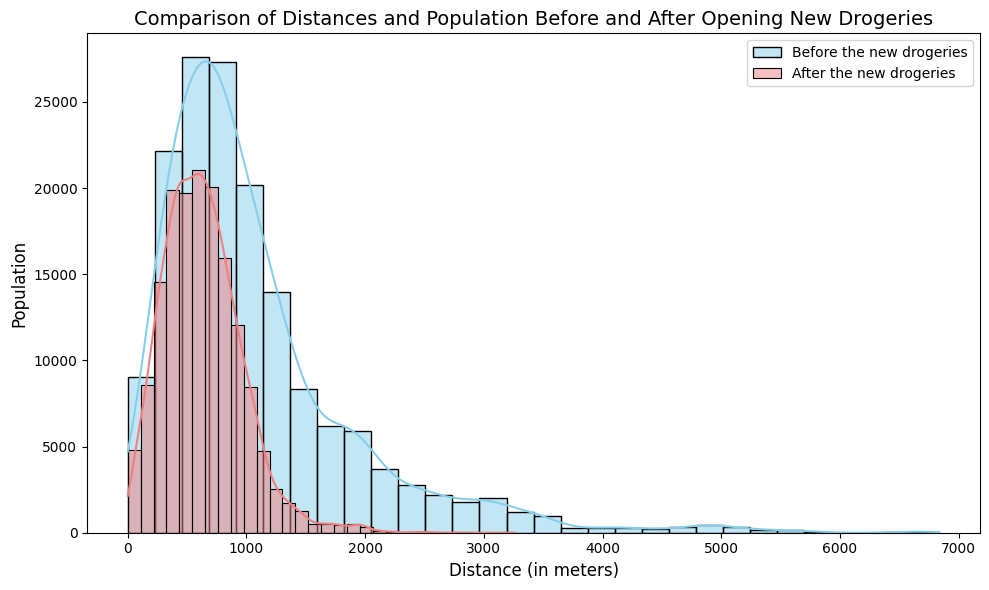

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a combined histogram for distances to the old and new drogeries
plt.figure(figsize=(10, 6))

# Histogram for the distance to the old drogerie (in blue)
sns.histplot(
    data=gdf,
    x="adjusted_ex_distance",
    weights=gdf["distributed_population"],
    kde=True,
    color='skyblue',
    bins=30,
    label='Before the new drogeries'
)

# Histogram for the distance to the new drogerie (in red)
sns.histplot(
    data=gdf,
    x="mynewdrog_distance",
    weights=gdf["distributed_population"],
    kde=True,
    color='lightcoral',
    bins=30,
    label='After the new drogeries'
)

# Title and axis labels
plt.title("Comparison of Distances and Population Before and After Opening New Drogeries", fontsize=14)
plt.xlabel("Distance (in meters)", fontsize=12)
plt.ylabel("Population", fontsize=12)

# Add legend
plt.legend(title="")

# Layout and show plot
plt.tight_layout()
plt.show()
